# EMA Analyses

Kendra Wyant

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──
✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.9     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

### Compliance

In [ ]:
path_shared <- format_path("studydata/risk/data_processed/shared")


visit_dates <- read_csv(file.path(path_shared, "visit_dates.csv"), col_types = cols())
ema_m <- vroom::vroom(file.path(path_shared, "ema_morning.csv"), col_types = vroom::cols()) %>% 
  mutate(start_date = with_tz(start_date, tzone = "America/Chicago"),
         subid = as.numeric(subid))
ema_l <- vroom::vroom(file.path(path_shared, "ema_later.csv"), col_types = vroom::cols()) %>% 
  mutate(start_date = with_tz(start_date, tzone = "America/Chicago"),
         subid = as.numeric(subid))
audio <- vroom::vroom(file.path(path_shared, "audio.csv"), col_types = vroom::cols()) %>% 
  mutate(subid = as.numeric(subid))


In [ ]:
visit_dates <- visit_dates %>%
  filter(!is.na(start_study)) %>%
  # filter out subid who started and ended study on same day - not considered enrolled
  filter(subid != 235) |> 
  mutate(subid = as.numeric(subid))

# function to map over
get_study_days <- function(the_subid, dates) {
  start_study <- dates %>% filter(subid == the_subid) %>% pull(start_study)
  end_study <- dates %>% filter(subid == the_subid) %>% pull(end_study)
  study_days <- tibble(subid = the_subid, study_day = seq(start_study, end_study - days(1), by = "day")) 
  return(study_days)
}

fu_1 <- visit_dates %>% 
  filter(!is.na(followup_1))

subids <- fu_1$subid
dates <- fu_1 %>% 
  select(subid, start_study, end_study)

study_dates <- subids %>% 
  map_dfr(~get_study_days(.x, dates))


In [ ]:
ema <- ema_m |> 
  select(subid, start_date) |> 
  full_join(ema_l |> select(subid, start_date), by = c("subid", "start_date")) |> 
  mutate(start_date = date(start_date)) |> 
  filter(subid %in% subids)

# count EMAs per day
ema_count_4x <- ema |>  
  count(subid, start_date) |>
  mutate(n = if_else(n > 4, 4, as.numeric(n)))

# left join with study dates
ema_study_dates <- study_dates |>
  left_join(ema_count_4x, by = c("subid", "study_day" = "start_date")) |> 
  mutate(n = if_else(is.na(n), 0, n)) |> 
  mutate(n_prompts = 4)

# slice into 7 day bins
ema_study_weeks <- ema_study_dates |> 
  group_by(subid) |> 
  slice(1:7) |> 
  mutate(week = 1) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(8:14) |> 
    mutate(week = 2)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(15:21) |> 
    mutate(week = 3)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(22:28) |> 
    mutate(week = 4)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(29:35) |> 
    mutate(week = 5)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(36:42) |> 
    mutate(week = 6)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(43:49) |> 
    mutate(week = 7)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(50:56) |> 
    mutate(week = 8)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(57:63) |> 
    mutate(week = 9)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(64:70) |> 
    mutate(week = 10)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(71:77) |> 
    mutate(week = 11)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(78:84) |> 
    mutate(week = 12)) |> 
  ungroup()

ema_week_compliance_4x <- ema_study_weeks |> 
  group_by(subid, week) |> 
  summarize(sum_n = sum(n), sum_prompts = sum(n_prompts), .groups = "rowwise") |> 
  mutate(compliance = sum_n/sum_prompts) |> 
  ungroup()

ema_week_compliance_1x <- ema_study_weeks |>
  mutate(n = if_else(n > 1, 1, n),
         n_prompts = 1) |> 
  group_by(subid, week) |> 
  summarize(sum_n = sum(n), sum_prompts = sum(n_prompts), .groups = "rowwise") |> 
  mutate(compliance = sum_n/sum_prompts) |> 
  ungroup()

week_compliance_all <- ema_week_compliance_4x |> 
              mutate(compliance = compliance*100) |> 
              group_by(week) |> 
              summarize(mean_compliance = mean(compliance),
                        n = n(),
                        sd = sd(compliance)) |> 
              mutate(se = sd/sqrt(n),
                     signal = "4x Daily") |> 
  bind_rows(ema_week_compliance_1x |> 
              mutate(compliance = compliance*100) |> 
              group_by(week) |> 
              summarize(mean_compliance = mean(compliance),
                        n = n(),
                        sd = sd(compliance)) |> 
              mutate(se = sd/sqrt(n),
                     signal = "1x Daily")) 


In [ ]:
# count audio surveys per day
audio_count <- audio %>%  
  count(subid, date) %>%
  mutate(n = if_else(n > 1, 1, as.numeric(n)))

# left join with study dates
audio_study_dates <- study_dates %>% 
  left_join(audio_count, by = c("subid", "study_day" = "date")) %>% 
  mutate(n = if_else(is.na(n), 0, n)) %>% 
  mutate(n_prompts = 1)

mean_audio <- audio_study_dates %>% 
  group_by(subid) %>% 
  summarize(n_total = sum(n), prompt_total = sum(n_prompts)) %>% 
  mutate(mean = n_total/prompt_total) %>% 
  ungroup() %>% 
  summarize(mean = mean(mean))

audio_study_weeks <- audio_study_dates %>% 
  group_by(subid) %>% 
  slice(1:7) %>% 
  mutate(week = 1) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(8:14) %>% 
    mutate(week = 2)) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(15:21) %>% 
    mutate(week = 3)) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(22:28) %>% 
    mutate(week = 4)) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(29:35) %>% 
    mutate(week = 5)) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(36:42) %>% 
    mutate(week = 6)) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(43:49) %>% 
    mutate(week = 7)) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(50:56) %>% 
    mutate(week = 8)) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(57:63) %>% 
    mutate(week = 9)) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(64:70) %>% 
    mutate(week = 10)) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(71:77) %>% 
    mutate(week = 11)) %>% 
  bind_rows(audio_study_dates %>% 
    group_by(subid) %>% 
    slice(78:84) %>% 
    mutate(week = 12)) %>% 
  ungroup()

audio_week_compliance <- audio_study_weeks %>% 
  group_by(subid, week) %>% 
  summarize(sum_n = sum(n), sum_prompts = sum(n_prompts), .groups = "rowwise") %>% 
  mutate(compliance = sum_n/sum_prompts*100) %>% 
  ungroup() |> 
    group_by(week) %>% 
  summarize(mean_compliance = mean(compliance),
            n = n(),
            sd = sd(compliance)) %>% 
  mutate(se = sd/sqrt(n),
           signal = "Audio Check-in") 


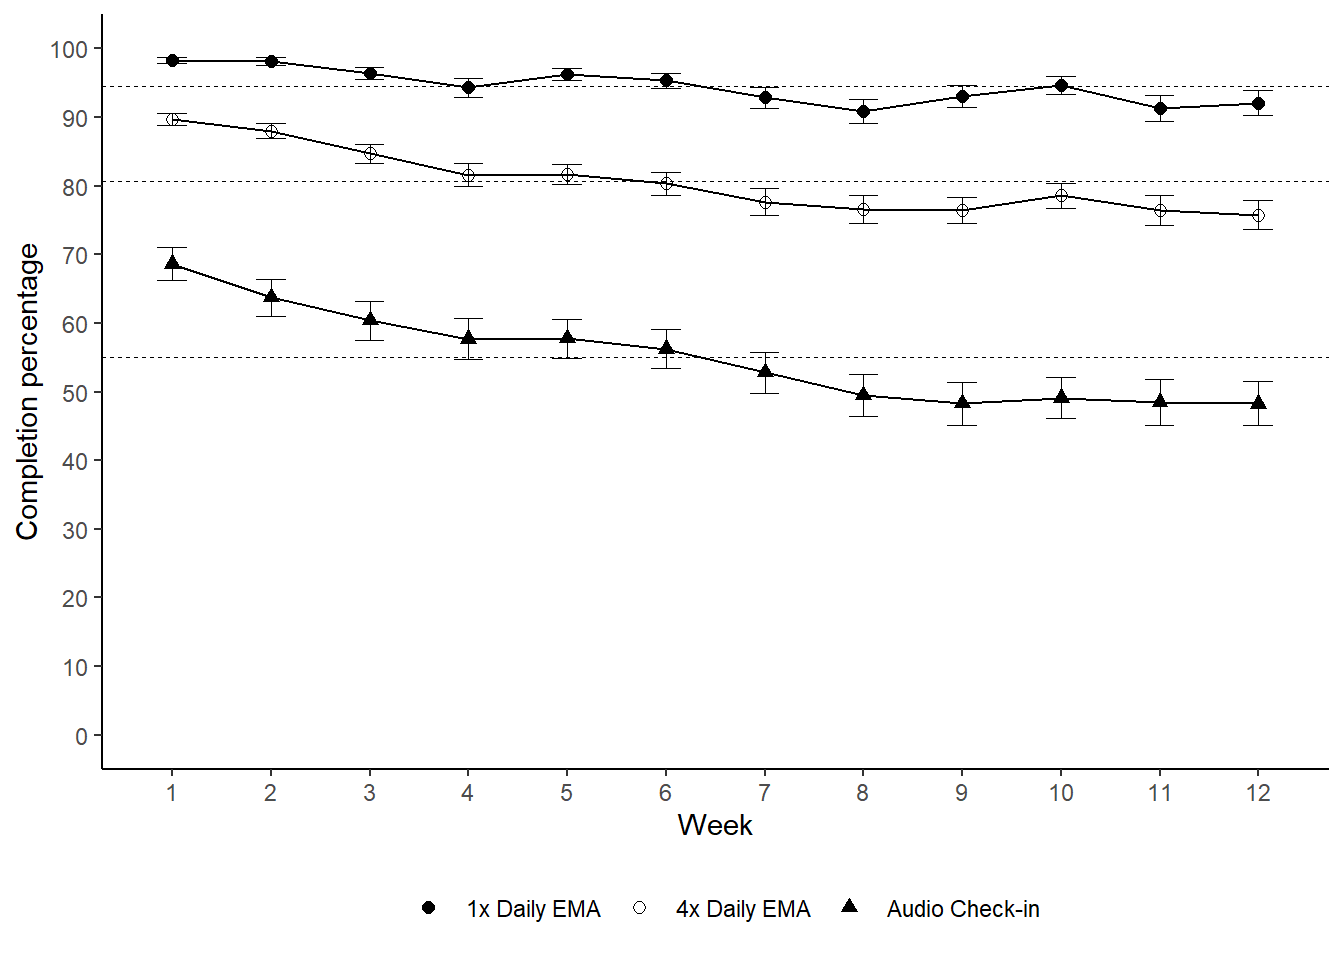

In [ ]:

audio_week_compliance %>% 
  bind_rows(week_compliance_all) |> 
  mutate(signal = factor(signal, levels = c("1x Daily", "4x Daily", "Audio Check-in"),
                         labels = c("1x Daily EMA", "4x Daily EMA", "Audio Check-in"))) |> 
  group_by(week, signal) |> 
  ggplot(aes(x = week, y = mean_compliance, group = signal, shape = signal)) +
  geom_point(size = 2) +
  geom_line() +
  geom_errorbar(aes(ymin = mean_compliance - se, ymax = mean_compliance + se), 
                width = .3, linewidth = .3) +
  theme_classic() +
  scale_shape_manual(values = c(19, 1, 17)) +
  scale_x_continuous(name = "Week", 
                     breaks = seq(1, 12, 1)) +
  scale_y_continuous(name = "Completion percentage", 
                     breaks = seq(0, 100, 10), 
                     limits = c(0, 100)) +
  geom_hline(aes(yintercept = mean_compliance), week_compliance_all |> 
               bind_rows(audio_week_compliance) |> 
               group_by(signal) |> 
               summarize(mean_compliance = mean(mean_compliance)),
             linetype = "dashed", linewidth = .3) +
  theme(legend.title = element_blank(),
        legend.position = "bottom")


### Acceptability Figures

In [ ]:
path_burden <- "P:/studydata/risk/data_processed/burden"


In [ ]:
data <- read_csv(file.path(path_burden, "acceptability.csv"), col_types = cols()) %>% 
  # wristband will be analyzed in supplemental - not enough observations
  select(-contains("wristband"))

# Adds Y label to histogram plots with 2 rows - code adapted from Stack overflow
add_global_label <- function(pwobj, Xlab = NULL, Ylab = NULL, Xgap = 0.03, Ygap = 0.03, ...) {
  ylabgrob <- patchwork::plot_spacer()
  if (!is.null(Ylab)) {
    ylabgrob <- ggplot() +
      geom_text(aes(x = 1, y = 1), label = Ylab, angle = 90, size = 4) +
      theme_void() 
  }
  if (!is.null(Ylab) & is.null(Xlab)) {
    return((ylabgrob + patchworkGrob(pwobj)) + 
             patchwork::plot_layout(widths = 100 * c(Ygap, 1 - Ygap)))
  }
  
  return(pwobj)
}


Pull out last observation for each participant

In [ ]:
# pull out last available sleep monitor data since this date will be earlier than last 
# survey date for some due to discontinuation of monitor
data_sleep <- data %>% 
  filter(!is.na(sleep_interfere)) %>% 
  group_by(subid) %>% 
  arrange(desc(date)) %>% 
  slice(1) %>% 
  ungroup() %>% 
  select(c(subid, starts_with("sleep_")))
  
# pull out most recent survey for each subid
data_last <- data %>% 
  select(-c(starts_with("sleep_"))) %>% 
  group_by(subid) %>% 
  arrange(desc(date)) %>% 
  slice(1) %>% 
  ungroup() %>% 
  # join with sleep data
  full_join(data_sleep, by = c("subid")) %>% 
  glimpse()


Rows: 154
Columns: 28
$ subid                    <dbl> 1, 2, 3, 5, 6, 7, 9, 10, 11, 15, 16, 18, 19, …
$ response_id              <chr> "R_3pb42s0hzoIFsk9", "R_1rvLRa6XSAGssBO", "R_…
$ date                     <date> 2017-06-05, 2017-06-16, 2017-06-21, 2017-09-…
$ daily_survey_interfere   <dbl> 1, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, …
$ daily_survey_dislike     <dbl> 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 1, 0, 2, -1,…
$ daily_survey_4_1year     <dbl> 1, -2, 2, 1, 1, 2, -1, 2, -1, 1, -1, 1, 0, -1…
$ daily_survey_1_1year     <dbl> 1, -2, 2, 1, 2, 2, 0, 2, -2, 1, 1, 2, 2, 2, -…
$ daily_survey_text        <chr> "The home surveys were easy to complete but I…
$ audio_checkin_interfere  <dbl> 1, 2, 1, 1, 1, 2, 1, 2, 2, -1, 1, -2, -1, 2, …
$ audio_checkin_dislike    <dbl> 1, 2, 2, 1, 1, 2, 1, 2, 0, -1, 1, -2, -2, 2, …
$ audio_checkin_1year      <dbl> 1, 2, 2, 1, 1, 2, 1, 2, -2, -1, 1, -2, -2, 2,…
$ audio_checkin_text       <chr> "I enjoyed the daily check more than all the …
$ carrying_phone_i

ℹ Please use `linewidth` instead.

ℹ Please use `after_stat(prop)` instead.

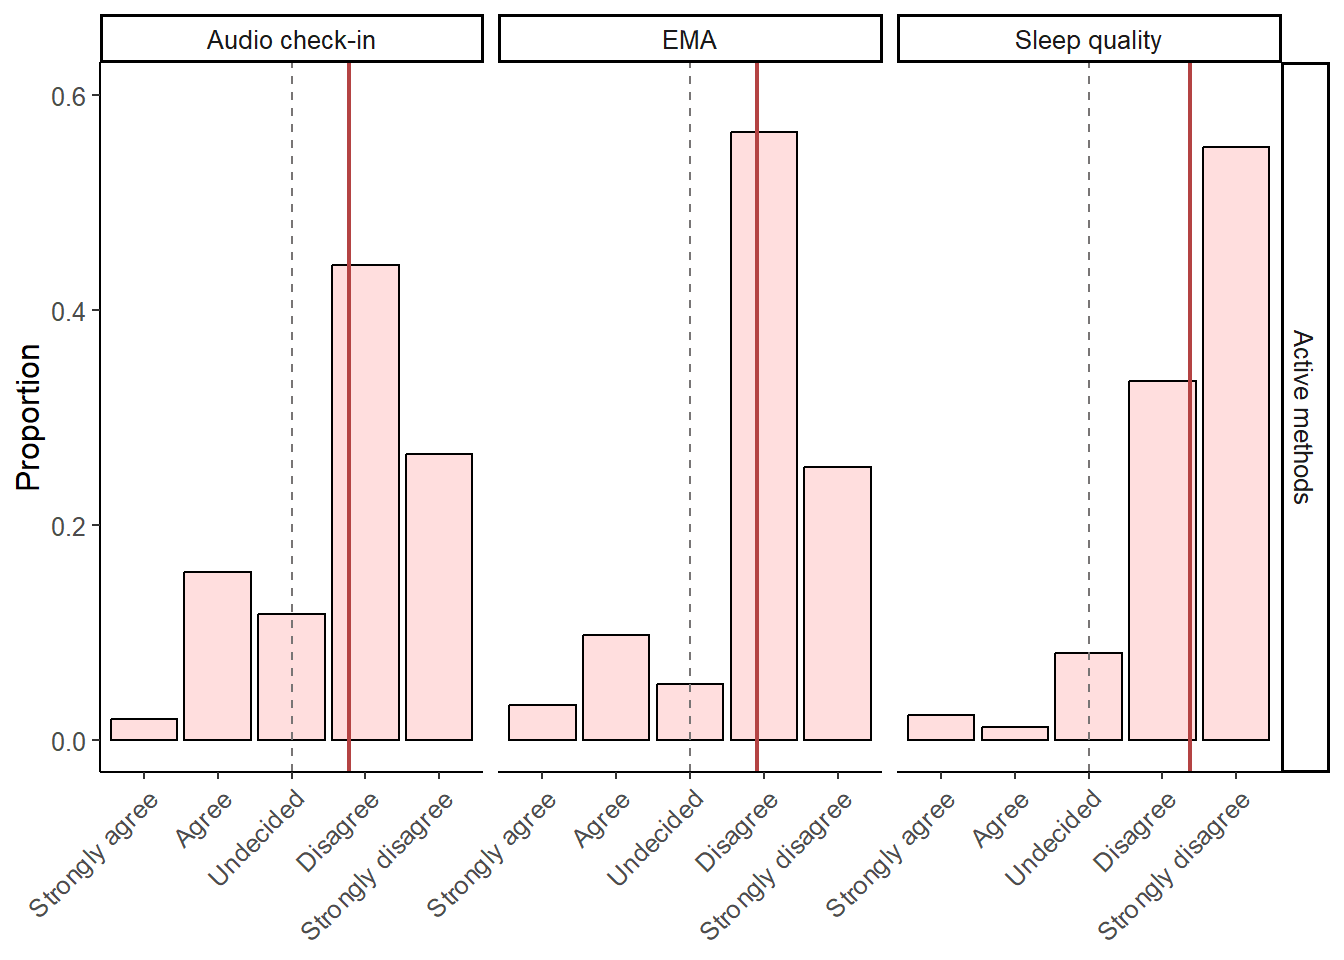

In [ ]:

interference_plot_data <- data_last %>% 
  select(contains("interfere"), -carrying_phone_interfere) %>%   
  pivot_longer(everything(), names_to = "measure", values_drop_na = TRUE) %>% 
  mutate(measure = factor(measure, 
                          levels = c("audio_checkin_interfere", "daily_survey_interfere", 
                                     "sleep_interfere"),
                          labels = c("Audio check-in", "EMA", "Sleep quality"))) %>% 
  mutate(value = factor(value, levels = c(-2:2), labels = c("Strongly agree", "Agree", "Undecided", "Disagree", "Strongly disagree"))) %>% 
  mutate(active = case_when(measure == "Audio check-in" ~ "Active methods",
                            measure == "EMA" ~ "Active methods",
                            measure == "Sleep quality" ~ "Active methods")) 

interference_plot <- interference_plot_data %>% 
  filter(measure == "Audio check-in" | measure == "EMA" | measure == "Sleep quality") %>% 
  ggplot(aes(x = value, y = ..prop.., group = measure)) +
  geom_bar(color = "black", fill = "#FFDEDE") +
  facet_grid(active ~ measure) +
  theme_classic() +
  labs(y = "Proportion",
       x = NULL) +
  theme(legend.position = "none",
        text = element_text(size = 12),
        axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(0, .6) +
  geom_vline(aes(xintercept = "Undecided"), linetype = "dashed", size = .4, color = "#787575") +
  geom_vline(aes(xintercept = means), interference_plot_data %>% 
  filter(measure == "Audio check-in" | measure == "EMA" | measure == "Sleep quality") %>% 
  group_by(measure) %>% 
  summarise(means = mean(as.numeric(value), na.rm = TRUE)), size = .705, color = "#b44343") 


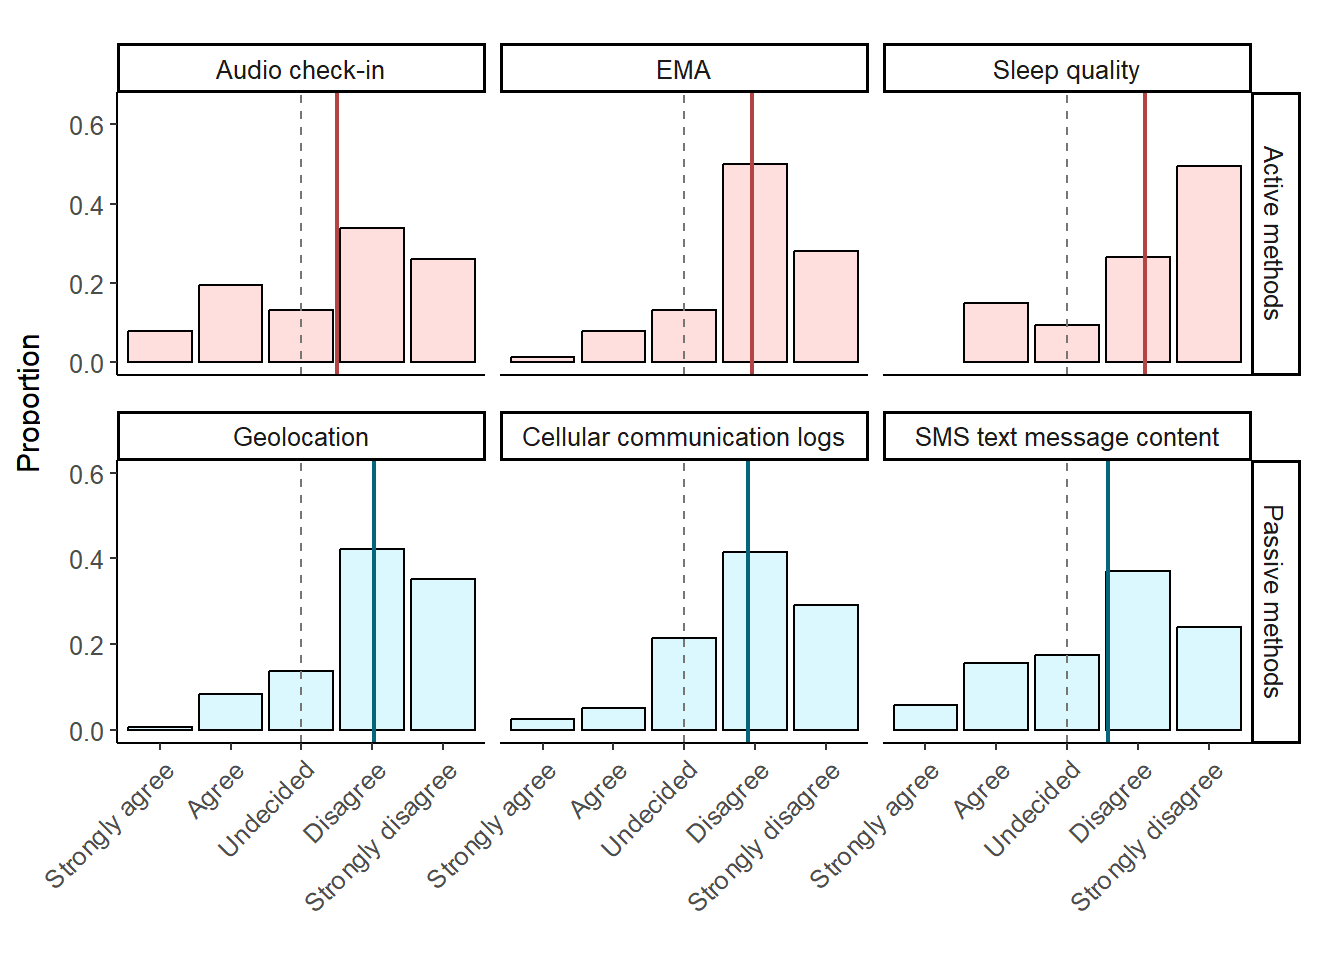

In [ ]:

dislike_plot_data <- data_last %>% 
  select(contains("dislike")) %>%  
  pivot_longer(everything(), names_to = "measure", values_drop_na = TRUE) %>% 
   mutate(measure = factor(measure, 
                          levels = c("audio_checkin_dislike", "daily_survey_dislike", "sleep_dislike",
                                     "location_dislike", "all_logs_dislike", "sms_content_dislike"),
                          labels = c("Audio check-in", "EMA", "Sleep quality",
                                     "Geolocation", "Cellular communication logs", "SMS text message content"))) %>% 
  mutate(value = factor(value, levels = c(-2:2), labels = c("Strongly agree", "Agree", "Undecided", "Disagree", "Strongly disagree"))) %>% 
  mutate(active = case_when(measure == "Audio check-in" ~ "Active methods",
                            measure == "EMA" ~ "Active methods",
                            measure == "Sleep quality" ~ "Active methods",
                            measure == "Geolocation" ~ "Passive methods",
                            measure == "Cellular communication logs" ~ "Passive methods",
                            measure == "SMS text message content" ~ "Passive methods")) 

active_dis <- dislike_plot_data %>% 
  filter(measure == "Audio check-in" | measure == "EMA" | measure == "Sleep quality") %>% 
  ggplot(aes(x = value, y = ..prop.., group = measure)) +
  geom_bar(color = "black", fill = "#FFDEDE") +
  facet_grid(active ~ measure) +
  theme_classic() +
  labs(y = NULL,
       x = NULL) +
  theme(legend.position = "none",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        text = element_text(size = 12)) +
  ylim(0, .65) +
  geom_vline(aes(xintercept = means), dislike_plot_data %>% 
  filter(measure == "Audio check-in" | measure == "EMA" | measure == "Sleep quality") %>% 
  group_by(measure) %>% 
  summarise(means = mean(as.numeric(value), na.rm = TRUE)), size = .705, color = "#b44343") +
  geom_vline(aes(xintercept = "Undecided"), linetype = "dashed", size = .4, color = "#787575") +
  theme(text = element_text(size = 12))


passive_dis <- dislike_plot_data %>% 
  filter(measure == "Geolocation" | measure == "Cellular communication logs" | measure == "SMS text message content") %>% 
  ggplot(aes(x = value, y = ..prop.., group = measure)) +
  geom_bar(color = "black", fill = "#DBF8FF") +
  facet_grid(active ~ measure) +
  theme_classic() +
  labs(y = NULL,
       x = NULL) +
    theme(legend.position = "none",
        text = element_text(size = 12),
        axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(0, .6) +
  geom_vline(aes(xintercept = means), dislike_plot_data %>% 
  filter(measure == "Geolocation" | measure == "Cellular communication logs" | measure == "SMS text message content") %>%  
  group_by(measure) %>% 
  summarise(means = mean(as.numeric(value), na.rm = TRUE)), size = .705, color = "#05667b") +
  geom_vline(aes(xintercept = "Undecided"), linetype = "dashed", size = .4, color = "#787575") 

dislike_plot <- wrap_plots(active_dis, passive_dis, ncol = 1)

dislike_plot <- dislike_plot  %>% 
  add_global_label(Ylab = "                   Proportion",
                   Ygap = .02
)

dislike_plot


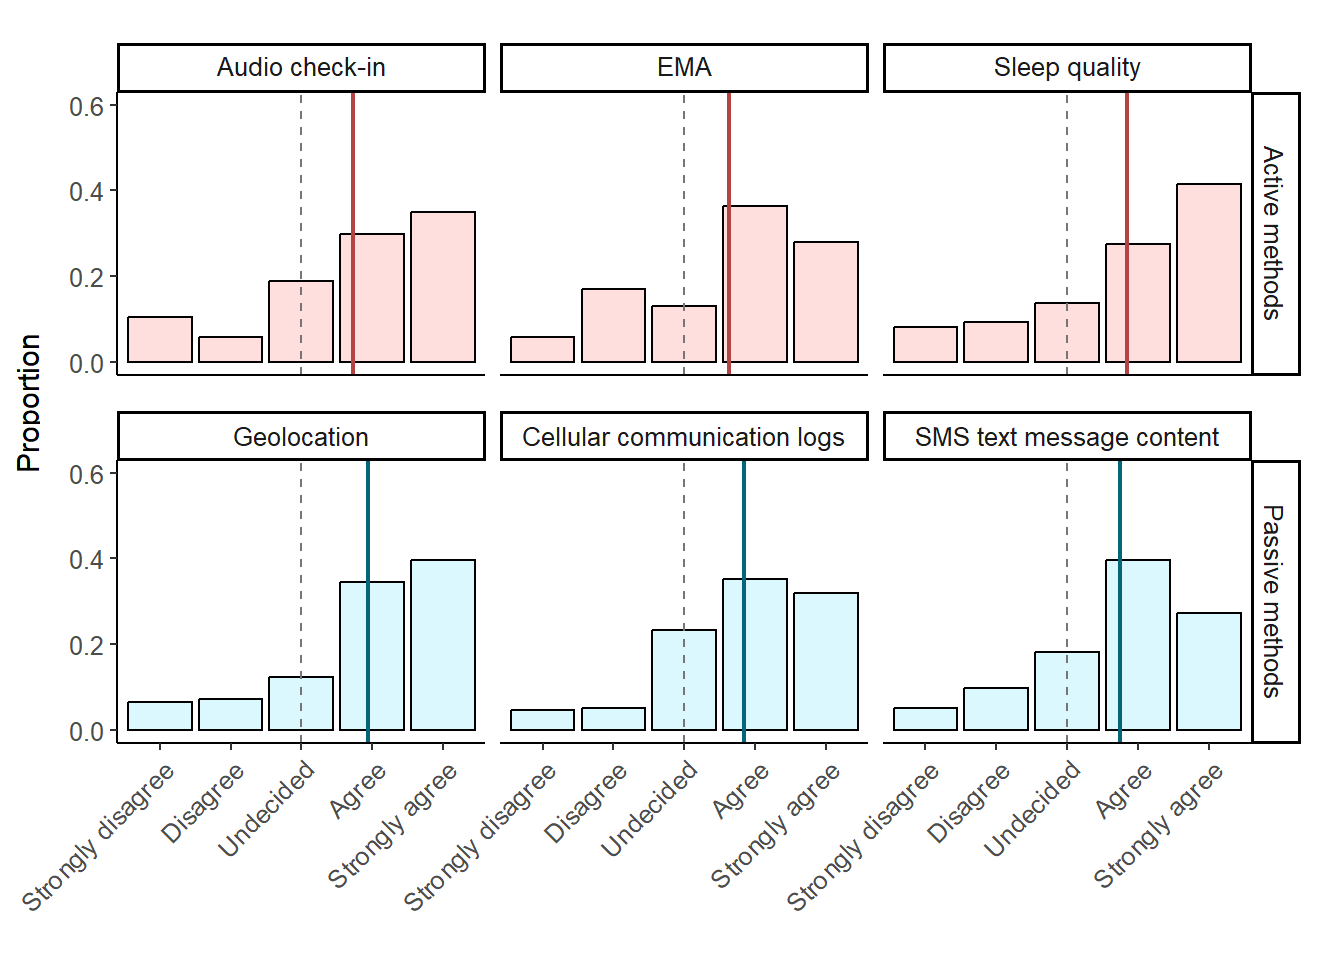

In [ ]:

willingness_plot_data <- data_last %>% 
  select(contains("1year")) %>%  
  pivot_longer(everything(), names_to = "measure", values_drop_na = TRUE) %>% 
  mutate(measure = factor(measure, 
                          levels = c("audio_checkin_1year", "daily_survey_4_1year", 
                                     "daily_survey_1_1year", "sleep_1year", "location_1year", 
                                     "all_logs_1year", "sms_content_1year"),
                          labels = c("Audio check-in", "EMA", "Daily Survey (x1)<i><sup>a</sup></i>",
                                     "Sleep quality", "Geolocation", "Cellular communication logs", 
                                     "SMS text message content"))) %>% 
  mutate(value = factor(value, levels = c(-2:2), labels = c("Strongly disagree", "Disagree", "Undecided", "Agree", "Strongly agree"))) %>% 
  mutate(active = case_when(measure == "Audio check-in" ~ "Active methods",
                            measure == "EMA" ~ "Active methods",
                            measure == "Sleep quality" ~ "Active methods",
                            measure == "Geolocation" ~ "Passive methods",
                            measure == "Cellular communication logs" ~ "Passive methods",
                            measure == "SMS text message content" ~ "Passive methods")) 

willingness_active <- willingness_plot_data %>% 
  filter(measure == "Audio check-in" | measure == "EMA" | measure == "Sleep quality") %>% 
  ggplot(aes(x = value, y = ..prop.., group = measure)) +
  geom_bar(color = "black", fill = "#FFDEDE") +
  facet_grid(active ~ measure) +
  theme_classic() +
  labs(y = NULL,
       x = NULL) +
  theme(legend.position = "none",
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        text = element_text(size = 12),
        strip.text = element_markdown()) +
  ylim(0, .6) +
  geom_vline(aes(xintercept = means), willingness_plot_data %>% 
  filter(measure == "Audio check-in" | measure == "EMA" | measure == "Sleep quality") %>% 
  group_by(measure) %>% 
  summarise(means = mean(as.numeric(value), na.rm = TRUE)), size = .705, color = "#b44343") +
  geom_vline(aes(xintercept = "Undecided"), linetype = "dashed", size = .4, color = "#787575")


willingness_passive <- willingness_plot_data %>% 
  filter(measure == "Geolocation" | measure == "Cellular communication logs" | measure == "SMS text message content") %>% 
  ggplot(aes(x = value, y = ..prop.., group = measure)) +
  geom_bar(color = "black", fill = "#DBF8FF") +
  facet_grid(active ~ measure) +
  theme_classic() +
  labs(y = NULL,
       x = NULL) +
    theme(legend.position = "none",
        text = element_text(size = 12),
        axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylim(0, .6) +
  geom_vline(aes(xintercept = means), willingness_plot_data %>% 
  filter(measure == "Geolocation" | measure == "Cellular communication logs" | measure == "SMS text message content") %>%  
  group_by(measure) %>% 
  summarise(means = mean(as.numeric(value), na.rm = TRUE)), size = .705, color = "#05667b") +
  geom_vline(aes(xintercept = "Undecided"), linetype = "dashed", size = .4, color = "#787575")

willingness_final_plot <- wrap_plots(willingness_active, willingness_passive, ncol = 1)

willingness_final_plot <- willingness_final_plot  %>% 
  add_global_label(Ylab = "                   Proportion",
                   Ygap = .02
)

willingness_final_plot
